- TinyLlama
    - A compact 1.1B language model (↔ 거대 언어 모델) pretrained on around 1 trillion tokens for approximately 3 epochs.

- PEFT
    - PEFT: huggingface.co/docs/transformers/main/en/peft
    - Parameter-Efficient Fine-Tuning of Billion-Scale Models on Low-Resource Hardware
    - 문제점 1 : 모델이 점점 커짐에 따라 시판 그래픽카드로 모델 전체를 파인튜닝하는것은 불가능해져가고있다.
    - 문제점 2 : 파인튜닝된 모델이 파인튜닝하기 이전의 사전학습된 모델과 똑같은 크기이기 때문에 파인튜닝된 모델을 사용하는 것 또한 (시간, 경제적으로) 비용이 많이 드는 일
    - 대부분의 파라미터를 프리징하고 일부의 파라미터만을 파인튜닝함으로써 저장공간과 계산을 대폭 줄였다. 파인튜닝할때 발생하는 문제점 중 하나인 catastrophic forgetting 또한 극복
    - 적은 데이터 체제(low-data-regime)에서 파인튜닝할때나 도메인 밖의 데이터(out-of-domain scenario)를 일반화할때 더욱 좋은 성능
    - **PEFT는 적은 수의 파라미터를 학습하는것만으로 모델 전체를 파인튜닝하는 것과 유사한 효과를 누릴 수 있도록 해준다.**

### Library

- bitsandbytes
    - model을 8-bit 포맷으로 set up하여 큰 gpu가 필요하지 않음.
    - 행렬 곱을 연산할 때 각 벡터를 독립적으로 처리하는 Vector-wise Quantization 방법을 적용하고 중요한 벡터는 16-bit로 표현하여 손실을 최소화 하는 등 8-bit와 16-bit를 혼용하는 기법을 통해 모델의 성능은 유지하면서 크기는 줄이는 성과를 보였다.
- accelerate
    - 기본 pytorch 코드를 통해 multi gpu를 사용하면 (DDP) 0번 gpu만 100% 사용되고 나머지 gpu는 예를 들어 60% 정도씩 덜 활용된다.
        
        각 gpu에서 loss를 계산하고 각 결과를 합해서 최종 loss를 구해야 하는데 합하는 연산을 0번 device에서 하기 때문에 0번의 소모만 커지기 때문. 
        
        accelerate를 사용하면 이러한 문제를 해결할 수 있다.
        
- DeepSpeed
    - 스케일링 등을 통해 학습 속도를 가속화하는 라이브러리
    - floating point를 32에서 16으로 줄이는 등의 스케일을 적용하여 학습 속도를 줄이지만 성능이 저하된다. 예를 들어 하루종일 걸리는 학습을 30분 정도(stage 3)로 단축하지만 성능도 그만큼 감수해야 한다. 때문에 분류 문제처럼 acc가 중요한 문제에는 DeepSpeed를 덜 사용하거나 사용하지 않는게 좋고, 텍스트 생성모델처럼 정량적 평가가 크게 중요하지 않은 문제(정성적 평가의 비중이 큰 문제)에는 DeepSpeed를 써도 감수할 만 하다
- from transformers import pipeline
    - 여러 모델을 묶어준다.

    ```
    pipe = pipeline("text-generation",
                model="TinyLlama/TinyLlama-1.1B-Chat-v1.0",
                torch_dtype=torch.bfloat16,
                device_map="auto")
    ```

- bf16: brainfloat16
    - 장점:넓은 수의 표현 범위 / 단점 : 표현 정밀도가 떨어지기 때문에 예를 들어 0에 가까운 수가 모조리 0으로 표현될 수 있음. 이 단점은 단지 숫자가 0이 되는것보다도 어떤 수를 0으로 나누는 상황이 생길 가능성을 높여서 문제이다.
    
    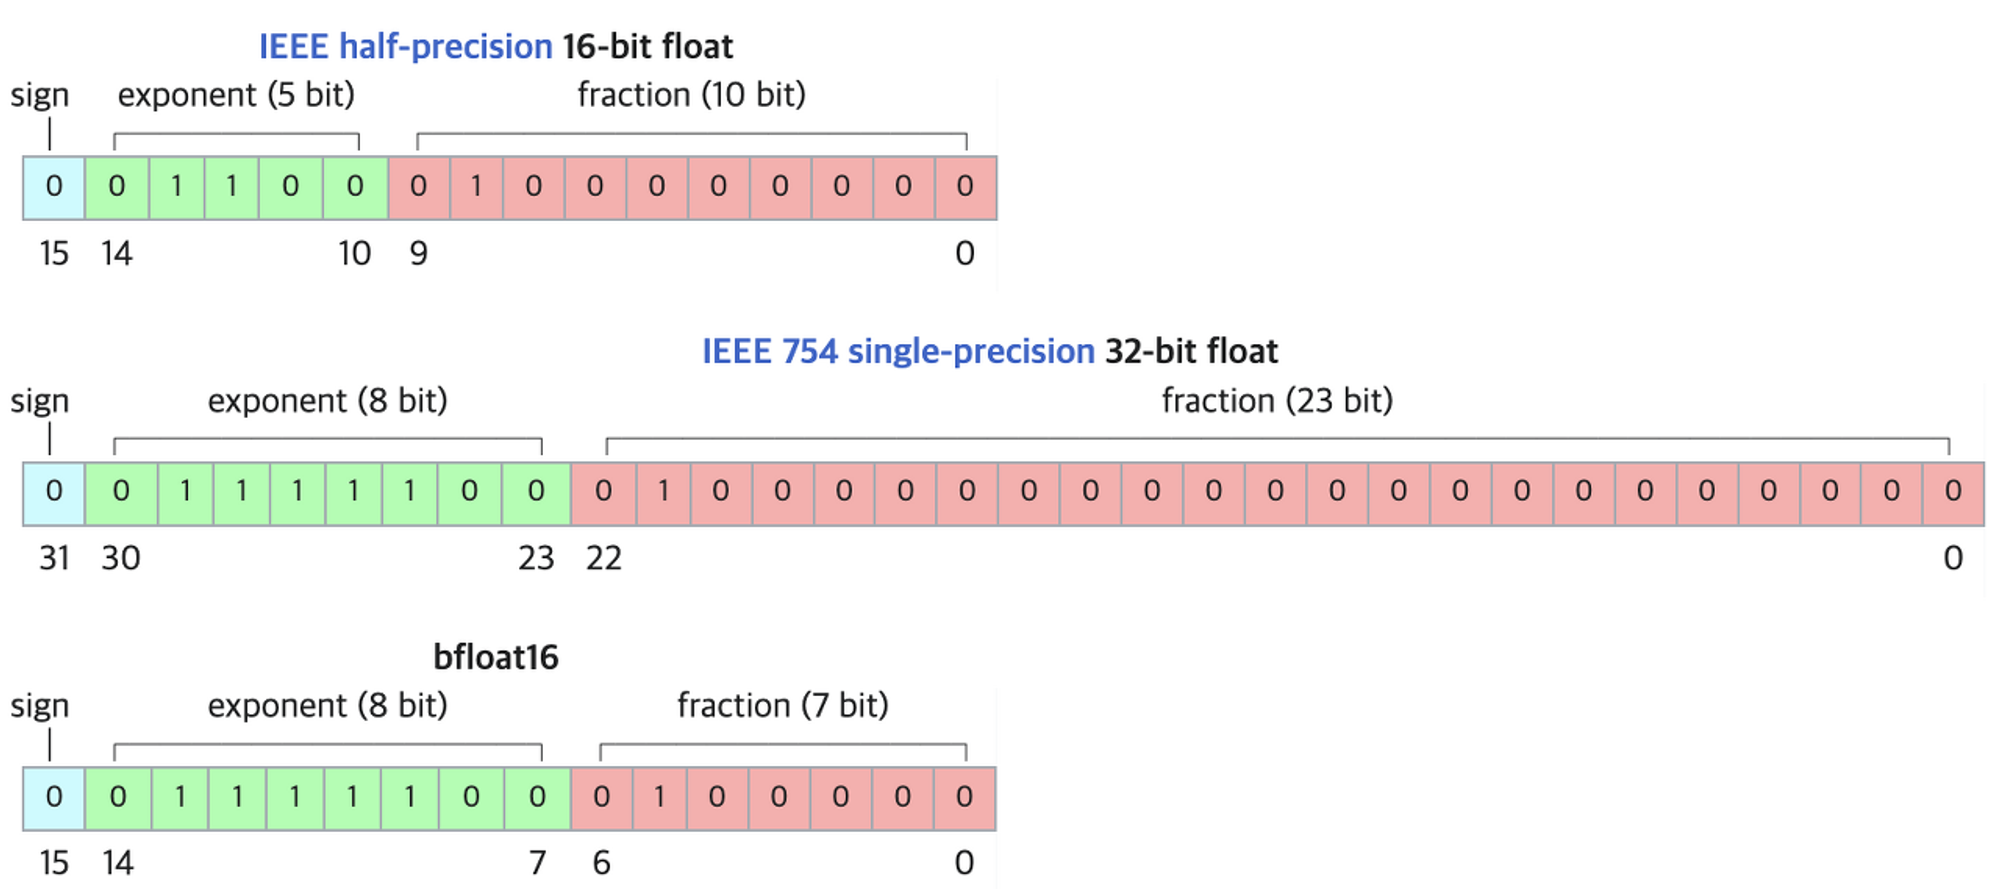
    
- chatgpt guidance  공개 안해줌.
- causal을 사용하기에 prompt를 유저에게 보여주지 않기 위해 삭제 replace(prompt, “”)
- chatgpt에서는 사용자와의 대화 history까지 input으로 들어가 마치 기억하는 것처럼 보임. 여기서는 아니기 때문에 과거에 예시를 새로운 것으로 착각하여 중복된 output을 낼 가능성이 있음. 때문에 input을 할 때 token에 과거의 output을 넣어주어야 하는데 token에 넣을 수 있는 메모리가 가득 차면 더 이상 생성할 수 없는 limitation이 있음.
- dp: import data_parallel as dp
    
    
    | DataParallel | DistributedDataParallel |
    | --- | --- |
    | More overhead; model is replicated and destroyed at each forward pass | Model is replicated only once |
    | Only supports single-node parallelism | Supports scaling to multiple machines |
    | Slower; uses multithreading on a single process and runs into Global Interpreter Lock (GIL) contention | Faster (no GIL contention) because it uses multiprocessing |

- multi_node는 accelerater가 해줌.
- **tinyllama로 peft를 켜서 모델을 생성 후 open dataset으로 실행 -> instruction dataset으로 실행, dp, ddp 사용**
- aica, GIST, nipa 등 연구원 전용 지원 혜택 받기
- colab은 multi gpu가 안됨
- colab pro + peft정도면 논문에 쓸 데이터 정도는 학습 가능